In [1]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth

dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [2]:
from scipy import stats

def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd", "modification_type"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "modification_type"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

/tmp/ipykernel_365061/3384330001.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax14)
/tmp/ipykernel_365061/3384330001.py:63: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax15)
/tmp/ipykernel_365061/3384330001.py:71: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax16)


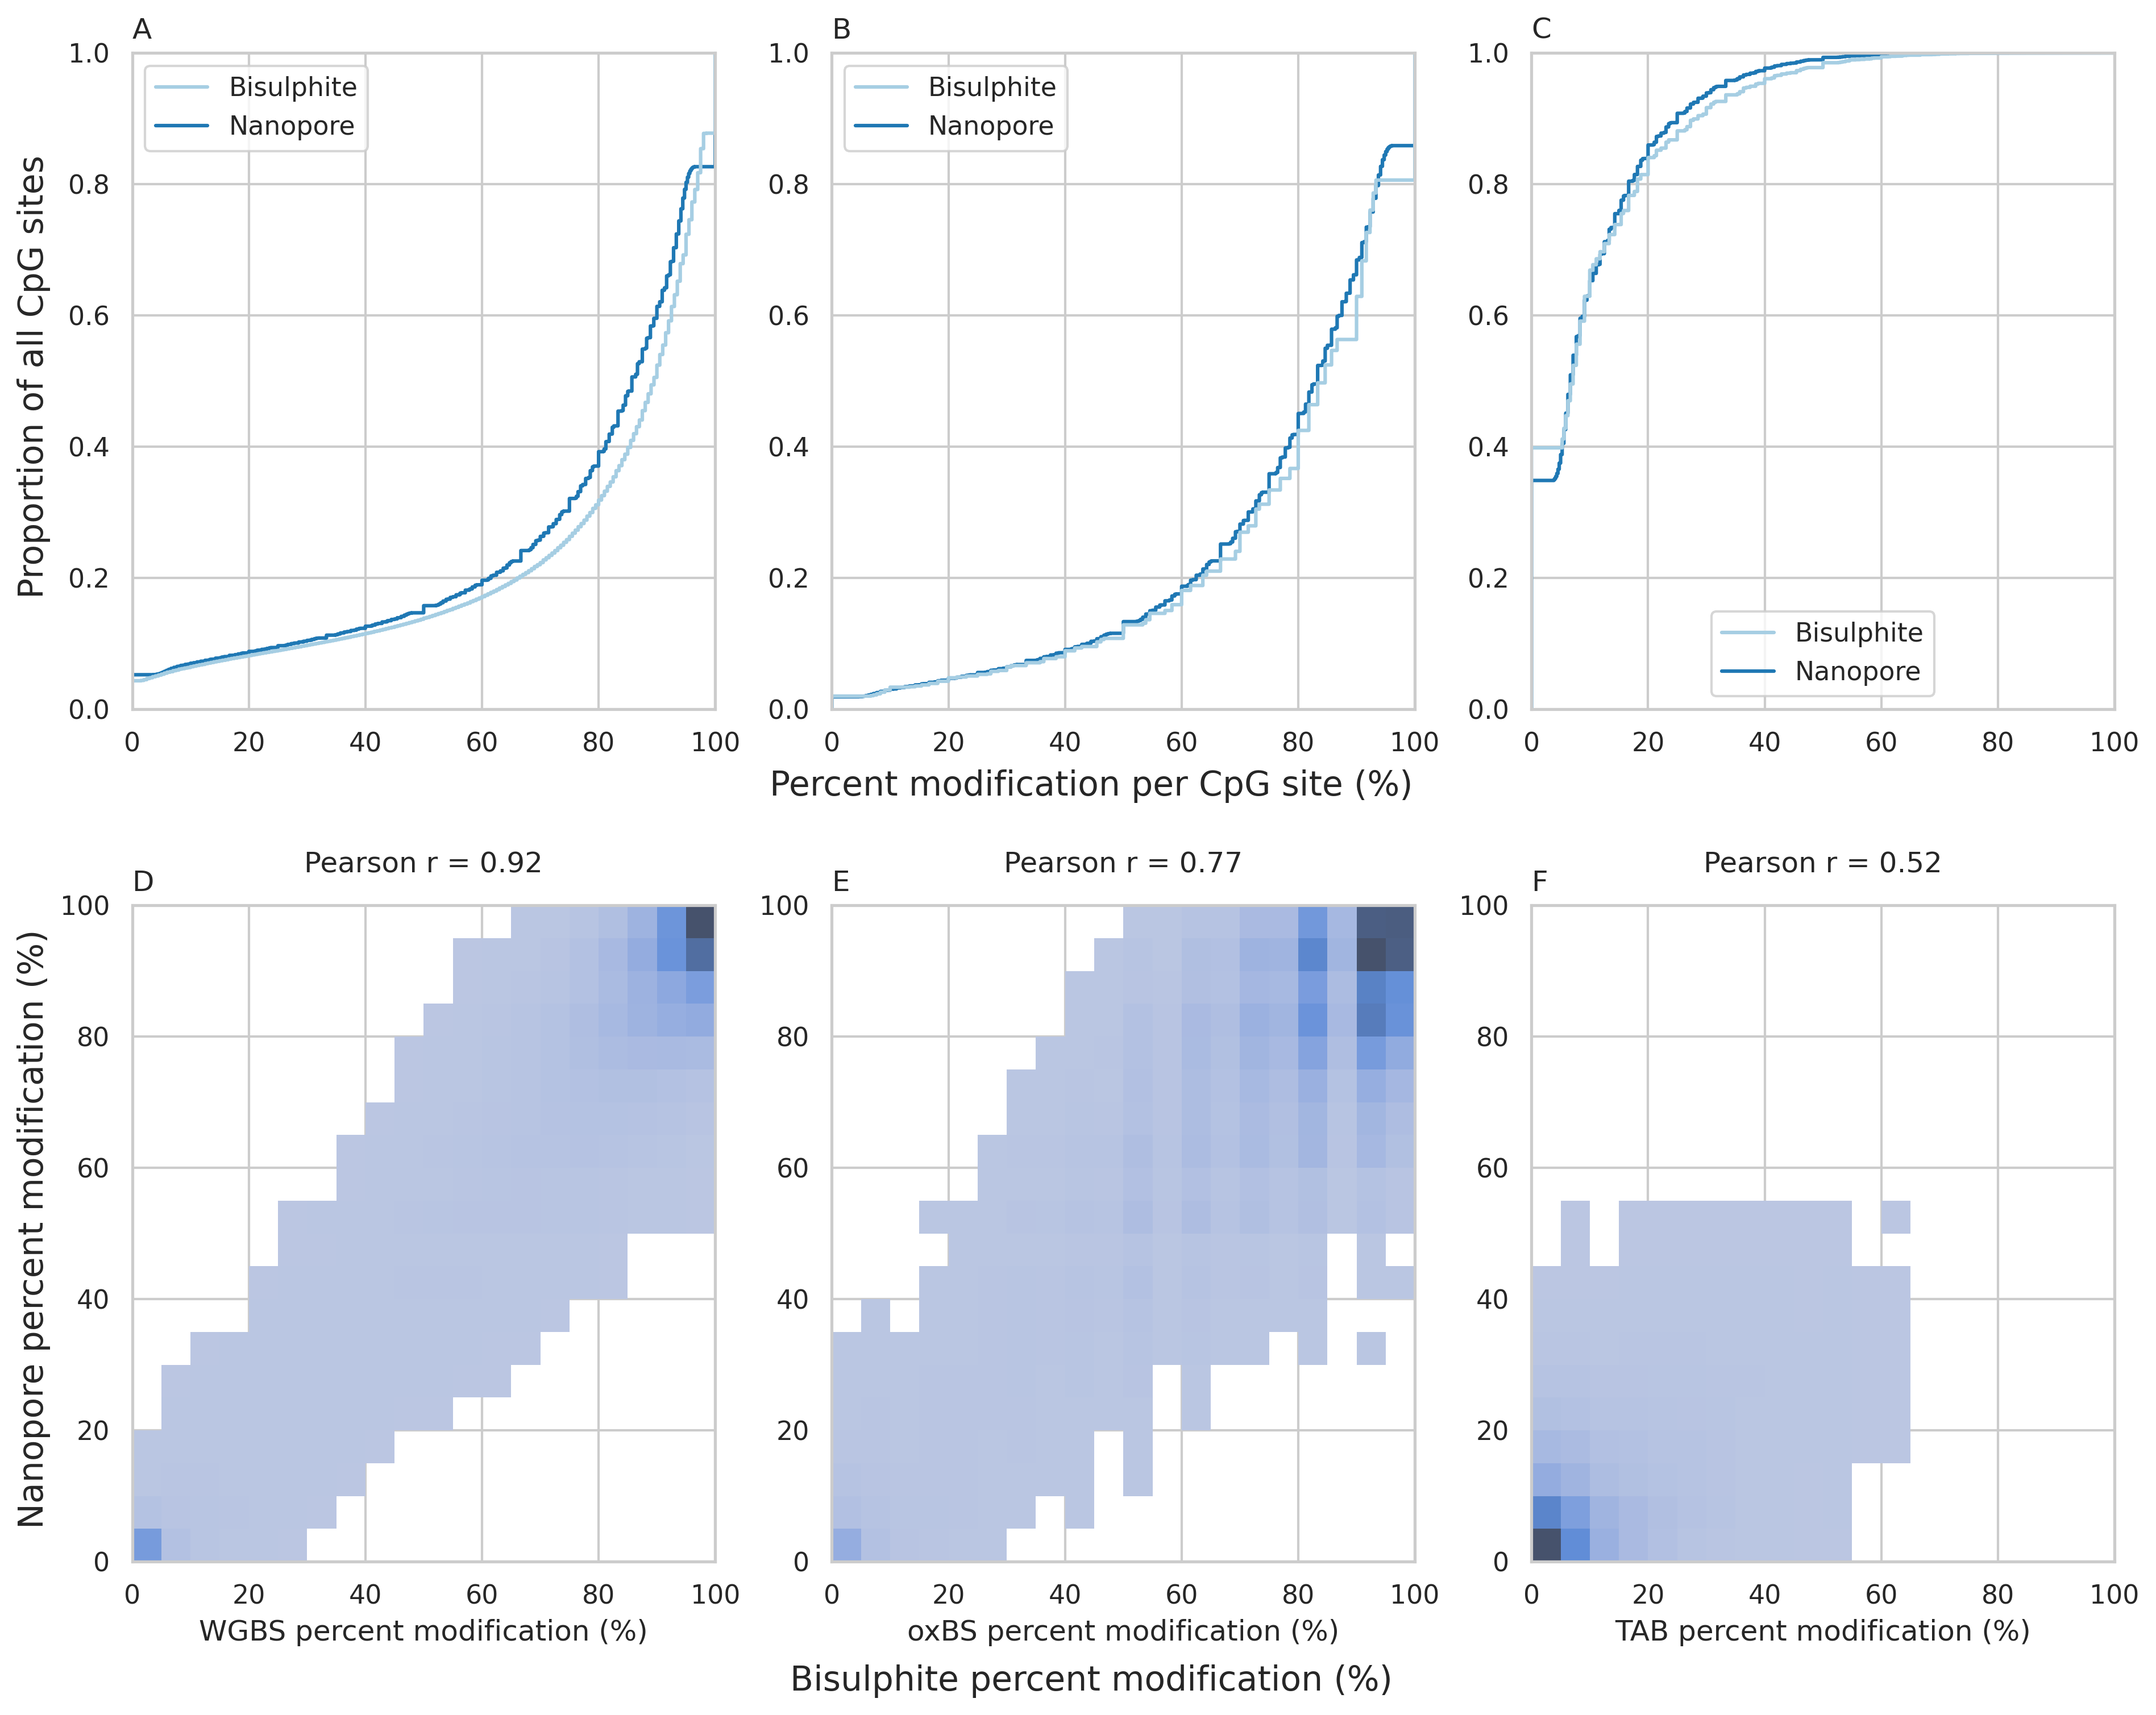

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supxlabel("Percent modification per CpG site (%)", y=0)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax11 = fig11.add_subplot(gs11[0, 0])
ax12 = fig11.add_subplot(gs11[0, 1])
ax13 = fig11.add_subplot(gs11[0, 2])

two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper left", title=None)
# ax11.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax11.set_ylabel(None)
ax11.set_xlabel(None)
ax11.set_title("A", loc="left")
ax11.set_xlim([0, 100])

mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax12)
sns.move_legend(ax12, "upper left", title=None)
# ax12.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax12.set_ylabel(None)
ax12.set_xlabel(None)
ax12.set_title("B", loc="left")
ax12.set_xlim([0, 100])

hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax13)
sns.move_legend(ax13, "lower center", title=None)
# ax13.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax13.set_ylabel(None)
ax13.set_xlabel(None)
ax13.set_xlim([0, 100])
ax13.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax14 = fig12.add_subplot(gs12[0, 0])
ax15 = fig12.add_subplot(gs12[0, 1])
ax16 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax14)
ax14.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax14.set_xlim((0, 100))
ax14.set_ylim((0, 100))
ax14.set_xlabel("WGBS percent modification (%)")
ax14.set_ylabel(None)
ax14.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax15)
ax15.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax15.set_xlim((0, 100))
ax15.set_ylim((0, 100))
ax15.set_xlabel("oxBS percent modification (%)")
ax15.set_ylabel(None)
ax15.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax16)
ax16.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax16.set_xlim((0, 100))
ax16.set_ylim((0, 100))
ax16.set_xlabel("TAB percent modification (%)")
ax16.set_ylabel(None)
ax16.set_title("F", loc="left")

fig1.show()

In [4]:
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix

def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)

    return plotROC(ax, label)

def make3ModConfusionMatrix(wide_mc_df, wide_hmc_df):
    wide_mc_df, wide_hmc_df = map(lambda df: df.drop(columns=["modification_type"]), [wide_mc_df, wide_hmc_df])
    merged_df = pd.merge(wide_mc_df, wide_hmc_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])

    merged_df["truth"] = np.select(
        [merged_df["percentMeth_Bisulphite_5mC"].gt(50),
         merged_df["percentMeth_Bisulphite_5hmC"].gt(50)],
         ["5mC", "5hmC"], default="C")

    merged_df["prediction"] = np.select(
        [merged_df["percentMeth_Nanopore_5mC"].gt(50),
         merged_df["percentMeth_Nanopore_5hmC"].gt(50)],
         ["5mC", "5hmC"], default="C")
    
    merged_df = merged_df.dropna()
    return confusion_matrix(merged_df["truth"], merged_df["prediction"], labels=["C", "5mC", "5hmC"], normalize="true")

def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

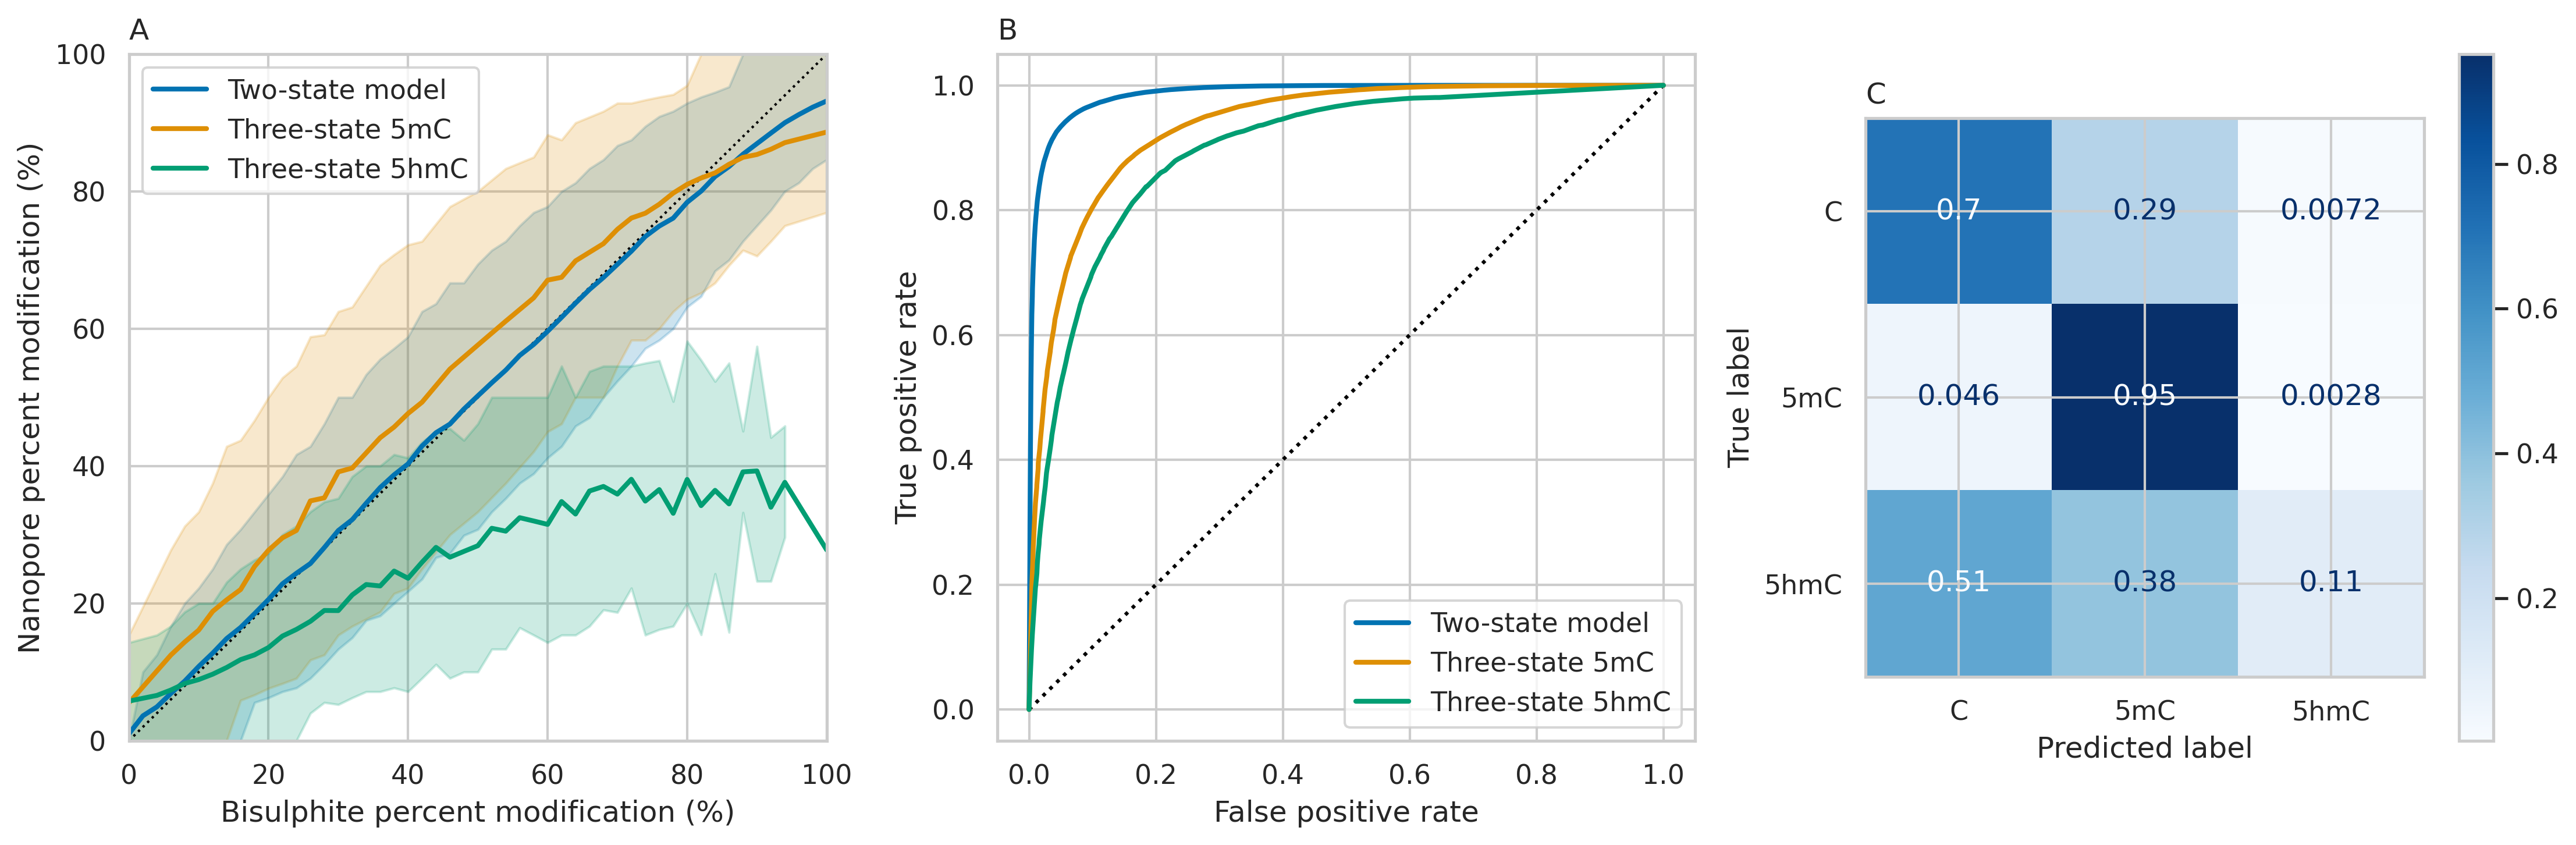

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax21 = fig2.add_subplot(gs2[0, 0])
ax21.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax21)
ax21.legend()
sns.move_legend(ax21, "upper left")
ax21.set_ylim((0, 100))
ax21.set_xlim((0, 100))
ax21.set_xlabel("Bisulphite percent modification (%)")
ax21.set_ylabel("Nanopore percent modification (%)")
ax21.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")
ROCmain(two_mod_wide, ax24, "Two-state model")
ROCmain(mc_df_wide, ax24, "Three-state 5mC")
ROCmain(hmc_df_wide, ax24, "Three-state 5hmC")
ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay(make3ModConfusionMatrix(mc_df_wide, hmc_df_wide), display_labels=["C", "5mC", "5hmC"]).plot(cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()